In [3]:

%load_ext autoreload
%autoreload 2
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pygame
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [5]:

# Function to select action based on policy
def select_action(policy_net, state):
    state = torch.FloatTensor(state)
    action_probs = policy_net(state)
    action = torch.multinomial(action_probs, 1).item()  # Sample from the probability distribution
    return action, action_probs[action]

# Function to compute discounted rewards
def compute_discounted_rewards(rewards, gamma):
    discounted_rewards = []
    cumulative_reward = 0
    for reward in reversed(rewards):
        cumulative_reward = reward + gamma * cumulative_reward
        discounted_rewards.insert(0, cumulative_reward)
    discounted_rewards = torch.tensor(discounted_rewards)
    return discounted_rewards 

In [7]:



# Main training loop
def train_cartpole(policy_net, optimizer, env, num_episodes=1000, gamma=0.99):
    for episode in range(num_episodes):
        state = env.reset()[0]
        log_probs = []
        rewards = []

        done = False
        while not done:
            action, prob = select_action(policy_net, state)
            next_state, reward, done, _, _ = env.step(action)

            log_probs.append(torch.log(prob))
            rewards.append(reward)

            state = next_state

            if done:
                discounted_rewards = compute_discounted_rewards(rewards, gamma)
                loss = 0
                for log_prob, reward in zip(log_probs, discounted_rewards):
                    loss -= log_prob * reward  # Loss is negative log probability * reward (Policy Gradient)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if (episode+1)%20 == 0:

                    print(f"Episode {episode}, Total Reward: {sum(rewards)}")
                break

# Initialize environment and policy
env = gym.make("CartPole-v1")
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
hidden_size = 128

policy_net = PolicyNetwork(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# Train the policy
train_cartpole(policy_net, optimizer, env, num_episodes=1000)
env.close()

Episode 19, Total Reward: 25.0
Episode 39, Total Reward: 83.0
Episode 59, Total Reward: 38.0
Episode 79, Total Reward: 54.0
Episode 99, Total Reward: 52.0
Episode 119, Total Reward: 105.0
Episode 139, Total Reward: 36.0
Episode 159, Total Reward: 36.0
Episode 179, Total Reward: 74.0
Episode 199, Total Reward: 139.0
Episode 219, Total Reward: 64.0
Episode 239, Total Reward: 68.0
Episode 259, Total Reward: 131.0
Episode 279, Total Reward: 77.0
Episode 299, Total Reward: 106.0
Episode 319, Total Reward: 193.0
Episode 339, Total Reward: 140.0
Episode 359, Total Reward: 172.0
Episode 379, Total Reward: 145.0
Episode 399, Total Reward: 71.0
Episode 419, Total Reward: 39.0
Episode 439, Total Reward: 64.0
Episode 459, Total Reward: 19.0
Episode 479, Total Reward: 60.0
Episode 499, Total Reward: 12.0
Episode 519, Total Reward: 14.0
Episode 539, Total Reward: 93.0
Episode 559, Total Reward: 104.0
Episode 579, Total Reward: 91.0
Episode 599, Total Reward: 125.0
Episode 619, Total Reward: 117.0
Ep

In [8]:
# Create the CartPole environment
env = gym.make('CartPole-v1', render_mode="rgb_array")
# Reset the environment to get the initial state
state, info = env.reset()
frames = [] 

# Run the environment for one episode
done = False
total_reward = 0
while not done:


    action,_ = select_action(policy_net, state) 
    
    # Step the environment forward based on the action
    next_state, reward, done, _, info = env.step(action)
    
    # Accumulate the total reward
    total_reward += reward
    
    # Update the current state
    state = next_state

    frame = env.render()
    frames.append(frame)

# Close the environment
env.close()

print(f'Total reward: {total_reward}')

Total reward: 671.0


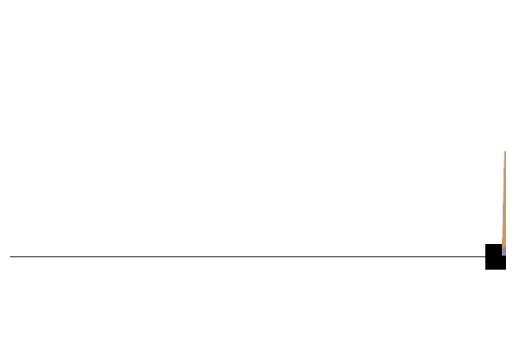

In [9]:
fig, ax = plt.subplots()
img = ax.imshow(frames[0])  # Initialize with the first frame
ax.axis('off')  
def animate(i):
    img.set_array(frames[i])
    return [img]
ani = animation.FuncAnimation(
    fig, animate, frames=len(frames), interval=100, blit=True
)
HTML(ani.to_jshtml())